# Seg-Zero: Reasoning-Chain Guided Segmentation on GCP CUDA

This notebook runs **Seg-Zero/VisionReasoner** for image segmentation with reasoning capabilities.

**Requirements:**
- NVIDIA GPU with 16GB+ VRAM (T4, A100, V100, etc.)
- CUDA 12.x environment

**What this notebook does:**
1. Install dependencies
2. Download VisionReasoner-7B model (~15GB)
3. Run inference on images
4. Run evaluation on ReasonSeg benchmark

## 1. Check GPU Availability

In [ ]:
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Fri Jan  2 13:33:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             46W /  400W |       6MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 2. Clone Repository & Install Dependencies


In [ ]:
# Clone Seg-Zero repository
!git clone https://github.com/dvlab-research/Seg-Zero.git
%cd Seg-Zero


fatal: destination path 'Seg-Zero' already exists and is not an empty directory.
/content/Seg-Zero


In [ ]:
# ⚠️ FIX: NumPy version conflict (required for Colab/Vertex AI)
# NumPy 2.x is incompatible with TensorFlow that Colab pre-installs
!pip uninstall numpy tensorflow tensorflow-cpu -y -q 2>/dev/null || true
!pip install numpy==1.26.4 -q
print("✅ NumPy fixed to version 1.26.4")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 87.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.0 requires tensorflow>=2.2.0, which is not installed.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 22.0.0 which is incompatible.
google-colabsqlviz 0.2.7 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
✅ NumPy fixed to version 1.26.4


### ⚠️ IMPORTANT: Restart Runtime Now!

After running the cell above, you **MUST restart the runtime**:
- **Colab:** Runtime → Restart runtime (or Ctrl+M then .)
- **Vertex AI:** Kernel → Restart Kernel

Then continue from the next cell (Install PyTorch).


In [ ]:
# Install PyTorch with CUDA support
!pip install torch==2.6.0 torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu124 -q


In [ ]:
# Install flash-attention (CUDA required)
!pip install flash-attn==2.7.4.post1 --no-build-isolation -q


In [ ]:
# Install Seg-Zero project
!pip install -e . -q


ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
# Install additional dependencies
!pip install qwen-vl-utils sam2 transformers==4.51.3 datasets -q


## 3. Download Pre-trained Model

Download VisionReasoner-7B (~15GB). This may take 10-20 minutes depending on network speed.


In [ ]:
# Install git-lfs for large file downloads
!apt-get update -qq && apt-get install git-lfs -y -qq
!git lfs install


W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.


In [ ]:
# Download VisionReasoner-7B model
!mkdir -p pretrained_models
%cd pretrained_models
!git clone https://huggingface.co/Ricky06662/VisionReasoner-7B
%cd ..


/content/pretrained_models
Cloning into 'VisionReasoner-7B'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 4), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (28/28), 1.72 MiB | 3.01 MiB/s, done.
Filtering content: 100% (5/5), 3.45 GiB | 55.39 MiB/s, done.
Encountered 3 file(s) that may not have been copied correctly on Windows:
	model-00002-of-00004.safetensors
	model-00001-of-00004.safetensors
	model-00003-of-00004.safetensors

See: `git lfs help smudge` for more details.
/content


In [ ]:
# Verify model download
!ls -lh pretrained_models/VisionReasoner-7B/


total 16G
-rw-r--r-- 1 root root  605 Jan  2 13:35 added_tokens.json
-rw-r--r-- 1 root root 1.1K Jan  2 13:35 chat_template.json
-rw-r--r-- 1 root root 1.4K Jan  2 13:35 config.json
-rw-r--r-- 1 root root  121 Jan  2 13:35 generation_config.json
-rw-r--r-- 1 root root 1.6M Jan  2 13:35 merges.txt
-rw-r--r-- 1 root root 4.7G Jan  2 13:36 model-00001-of-00004.safetensors
-rw-r--r-- 1 root root 4.6G Jan  2 13:35 model-00002-of-00004.safetensors
-rw-r--r-- 1 root root 4.7G Jan  2 13:36 model-00003-of-00004.safetensors
-rw-r--r-- 1 root root 1.6G Jan  2 13:35 model-00004-of-00004.safetensors
-rw-r--r-- 1 root root  57K Jan  2 13:35 model.safetensors.index.json
-rw-r--r-- 1 root root  575 Jan  2 13:35 preprocessor_config.json
-rw-r--r-- 1 root root 3.6K Jan  2 13:35 README.md
-rw-r--r-- 1 root root  613 Jan  2 13:35 special_tokens_map.json
-rw-r--r-- 1 root root 7.2K Jan  2 13:35 tokenizer_config.json
-rw-r--r-- 1 root root  11M Jan  2 13:35 tokenizer.json
-rw-r--r-- 1 root root 2.7M Jan  2 

In [ ]:
%cd /content/Seg-Zero

/content/Seg-Zero


In [ ]:
# Run inference with default test image
# Default question: "What can I have if I'm thirsty?"
!python inference_scripts/infer_multi_object.py


Loading checkpoint shards: 100% 4/4 [00:04<00:00,  1.23s/it]
sam2_hiera_large.pt: 100% 898M/898M [00:02<00:00, 362MB/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
User question:  What can I have if I'm thirsty?
<think> The question asks for items that can be consumed if one is thirsty. In the image, there are two glasses that appear to contain beverages, which are the most likely candidates for something to drink. The other items, such as the salad, fruit platter, and sandwich, are not drinks and are not suitable for quenching thirst.</think>
<answer>[{"bbox_2d": [129,151,220,498], "point_2d": [178,358]}, {"bbox_2d": [525,156,615,610], "point_2d": [568,375]}]</answer>
[[217, 226], [692, 237]] 2
Thinking proces

## 4. Run Inference

### 4.1 Quick Test with Default Image


In [ ]:
%cd /content/Seg-Zero

/content/Seg-Zero


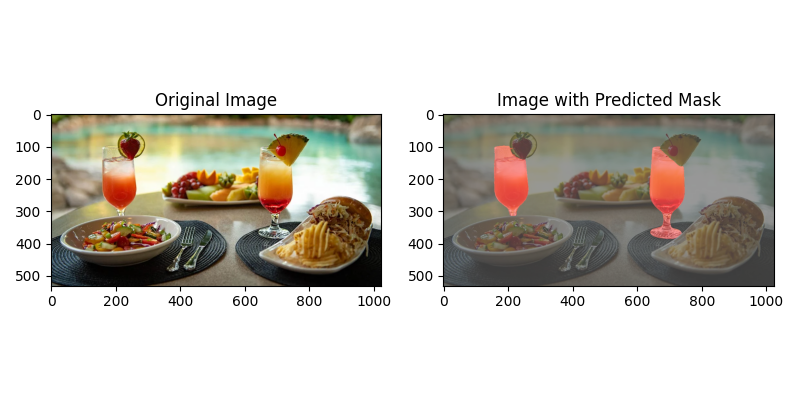

In [ ]:
# Display the result
from IPython.display import Image, display
display(Image(filename='inference_scripts/test_output_multiobject.png'))


### 4.2 Run with Custom Image and Question


In [ ]:
# ===== MODIFY THESE VALUES =====
IMAGE_PATH = "assets/dog.jpg"  # Path to your image
QUESTION = "Where is the dog in the image?"  # Your question about the image
OUTPUT_PATH = "inference_scripts/custom_output.png"
# ================================


In [ ]:
# Run inference with custom parameters
!python inference_scripts/infer_multi_object.py \
    --image_path "{IMAGE_PATH}" \
    --text "{QUESTION}" \
    --output_path "{OUTPUT_PATH}"


Loading checkpoint shards: 100% 4/4 [00:04<00:00,  1.23s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
User question:  Where is the dog in the image?
<think> The task involves identifying the location of the dog in the image and comparing it with other objects. The dog is clearly visible in the foreground, running on a patch of dirt surrounded by grass. The background includes trees, people, and a fence, but the focus is on the dog.</think>
<answer>[{"bbox_2d": [349,383,439,691], "point_2d": [396,515]}]</answer>
[[1503, 1226]] 1
Thinking process:   The task involves identifying the location of the dog in the image and comparing it with other objects. The dog is clearly visible in the foreground, running on a 

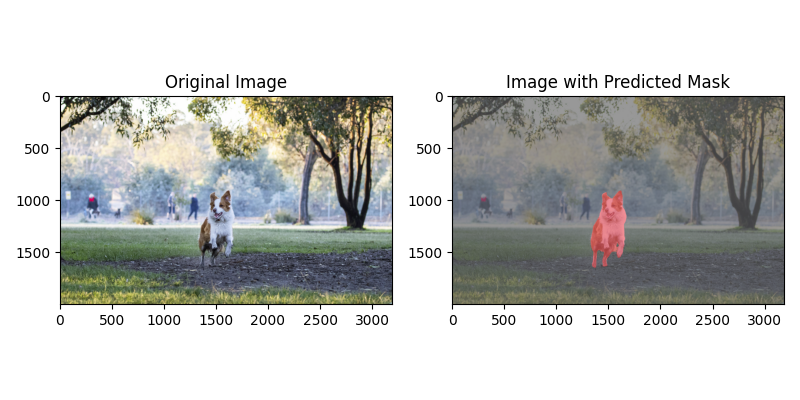

In [ ]:
# Display custom result
from IPython.display import Image, display
display(Image(filename=OUTPUT_PATH))


In [ ]:
# ===== MODIFY THESE VALUES =====
IMAGE_PATH = "assets/catwith-baby.jpg"  # Path to your image
QUESTION = "Where is the cat in the image?"  # Your question about the image
OUTPUT_PATH = "inference_scripts/custom_output_cat.png"
# ================================


In [ ]:
# Run inference with custom parameters
!python inference_scripts/infer_multi_object.py \
    --image_path "{IMAGE_PATH}" \
    --text "{QUESTION}" \
    --output_path "{OUTPUT_PATH}"


Loading checkpoint shards: 100% 4/4 [00:04<00:00,  1.21s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
User question:  Where is the cat in the image?
<think> The task involves identifying the location of the cat in the image and comparing it to other objects. The image shows a baby and a cat lying on a bed. The cat is clearly visible and is positioned on the left side of the image, partially covered by a green knitted blanket. The baby is on the right side, also under a white knitted blanket. The cat is the only animal in the image, and it is distinct in its gray color and size compared to the baby.</think>
<answer>[{"bbox_2d": [209,275,414,698], "point_2d": [273,506]}]</answer>
[[325, 433]] 1
Thinking proces

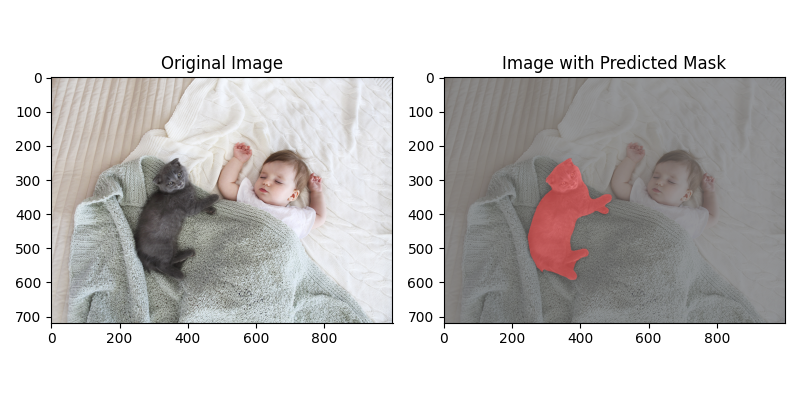

In [ ]:
# Display custom result
from IPython.display import Image, display
display(Image(filename=OUTPUT_PATH))

In [ ]:
# ===== MODIFY THESE VALUES =====
IMAGE_PATH = "assets/car-park.jpeg"  # Path to your image
QUESTION = "point me to the car in the image"  # Your question about the image
OUTPUT_PATH = "inference_scripts/custom_output_car.png"
# ================================


In [ ]:
# Run inference with custom parameters
!python inference_scripts/infer_multi_object.py \
    --image_path "{IMAGE_PATH}" \
    --text "{QUESTION}" \
    --output_path "{OUTPUT_PATH}"


Loading checkpoint shards: 100% 4/4 [00:04<00:00,  1.21s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
User question:  point me to the car in the image
<think> The task involves identifying the car in the image and providing its bounding box coordinates. The car is clearly visible in the center of the image, parked on the side of the road. The bounding box should encompass the entire car, including its wheels and body.</think>
<answer>[{"bbox_2d": [308,428,555,609], "point_2d": [425,492]}]</answer>
[[139, 107]] 1
Thinking process:   The task involves identifying the car in the image and providing its bounding box coordinates. The car is clearly visible in the center of the image, parked on the side of the roa

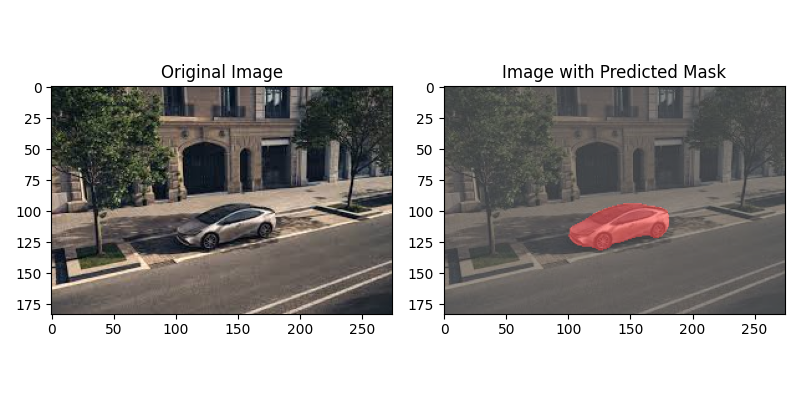

In [ ]:
# Display custom result
from IPython.display import Image, display
display(Image(filename=OUTPUT_PATH))